# Text analysis - 20Newsgroup

In [1]:
import pandas as pd
import numpy as np
from sklearn.datasets import fetch_20newsgroups

In [2]:
# pip install git+ssh://git@github.com/anniegray52/relastat.git

In [3]:
import relastat as rs

2024-02-05 13:03:18.184948: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-05 13:03:18.237887: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-05 13:03:18.238576: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-05 13:03:19.247273: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/ag16115/.local/lib/python3.8/site-packages/ot/backend.py:2998: UserWarning: To use TensorflowBackend, you need to activate the tensorflow numpy API. You can activate it by running: 
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
  register_backe

Import data and create dataframe

In [4]:
newsgroups = fetch_20newsgroups() 

df = pd.DataFrame()
df["data"] = newsgroups["data"]
df["target"] = newsgroups["target"]
df["target_names"] = df.target.apply(
    lambda row: newsgroups["target_names"][row])
df[['layer1', 'layer2']] = df['target_names'].str.split('.', n=1, expand=True)

Create td-idf features

In [5]:
# ## use random sample of data
n = 5000
df = df.sample(n=n, replace=False, random_state=22).reset_index(drop=True)

In [6]:
Y, attributes = rs.matrix_from_text(df, 'data', remove_stopwords=True, clean_text=True,
                                    remove_email_addresses=True, update_stopwords=['subject'],
                                    min_df=5, max_df=len(df)-1000)

In [7]:
(n,p) = Y.shape
print("n = {}, p = {}".format(n,p))

n = 5000, p = 12804


Perform dimension selection using Wasserstein distances

In [8]:
# rmin = 1
# rmax = 20
# ws = rs.wasserstein_dim_select(Y,rmin = rmin, rmax = rmax)
# dim = rmin + np.argmin(ws)
# print(f'Dimension selected: {np.argmin(ws) + rmin}')
dim =19

## PCA and tSNE

Calculate PCA embedding

In [9]:
zeta = rs.embed(Y, dim)

Apply t-SNE

In [10]:
from sklearn.manifold import TSNE

tsne_zeta = TSNE(n_components=2, perplexity=30).fit_transform(zeta)

Make dataframes of PCA embedding and t-SNE embedding for plotting

In [11]:
zeta_df = pd.DataFrame(zeta[:, :2])
zeta_df["target"] = np.array(df['target_names'])
targets = zeta_df["target"].unique()
targets = sorted(targets)
labels = df['target']

tsne_zeta_df = pd.DataFrame(tsne_zeta)
tsne_zeta_df["target"] = np.array(df['target_names'])
targets = tsne_zeta_df["target"].unique()
targets = sorted(targets)

Colours dictionary where topics from the same theme have different shades of the same colour

In [12]:
target_colour = {'alt.atheism': 'goldenrod',
                 'comp.graphics': 'steelblue',
                 'comp.os.ms-windows.misc': 'skyblue',
                 'comp.sys.ibm.pc.hardware': 'lightblue',
                 'comp.sys.mac.hardware': 'powderblue',
                 'comp.windows.x': 'deepskyblue',
                 'misc.forsale': 'maroon',
                 'rec.autos': 'limegreen',
                 'rec.motorcycles': 'green',
                 'rec.sport.baseball': 'yellowgreen',
                 'rec.sport.hockey': 'olivedrab',
                 'sci.crypt': 'pink',
                 'sci.electronics': 'plum',
                 'sci.med': 'orchid',
                 'sci.space': 'palevioletred',
                 'soc.religion.christian': 'darkgoldenrod',
                 'talk.politics.guns': 'coral',
                 'talk.politics.mideast': 'tomato',
                 'talk.politics.misc': 'darksalmon',
                 'talk.religion.misc': 'gold'}

Plot PCA on the LHS and PCA + t-SNE on the RHS

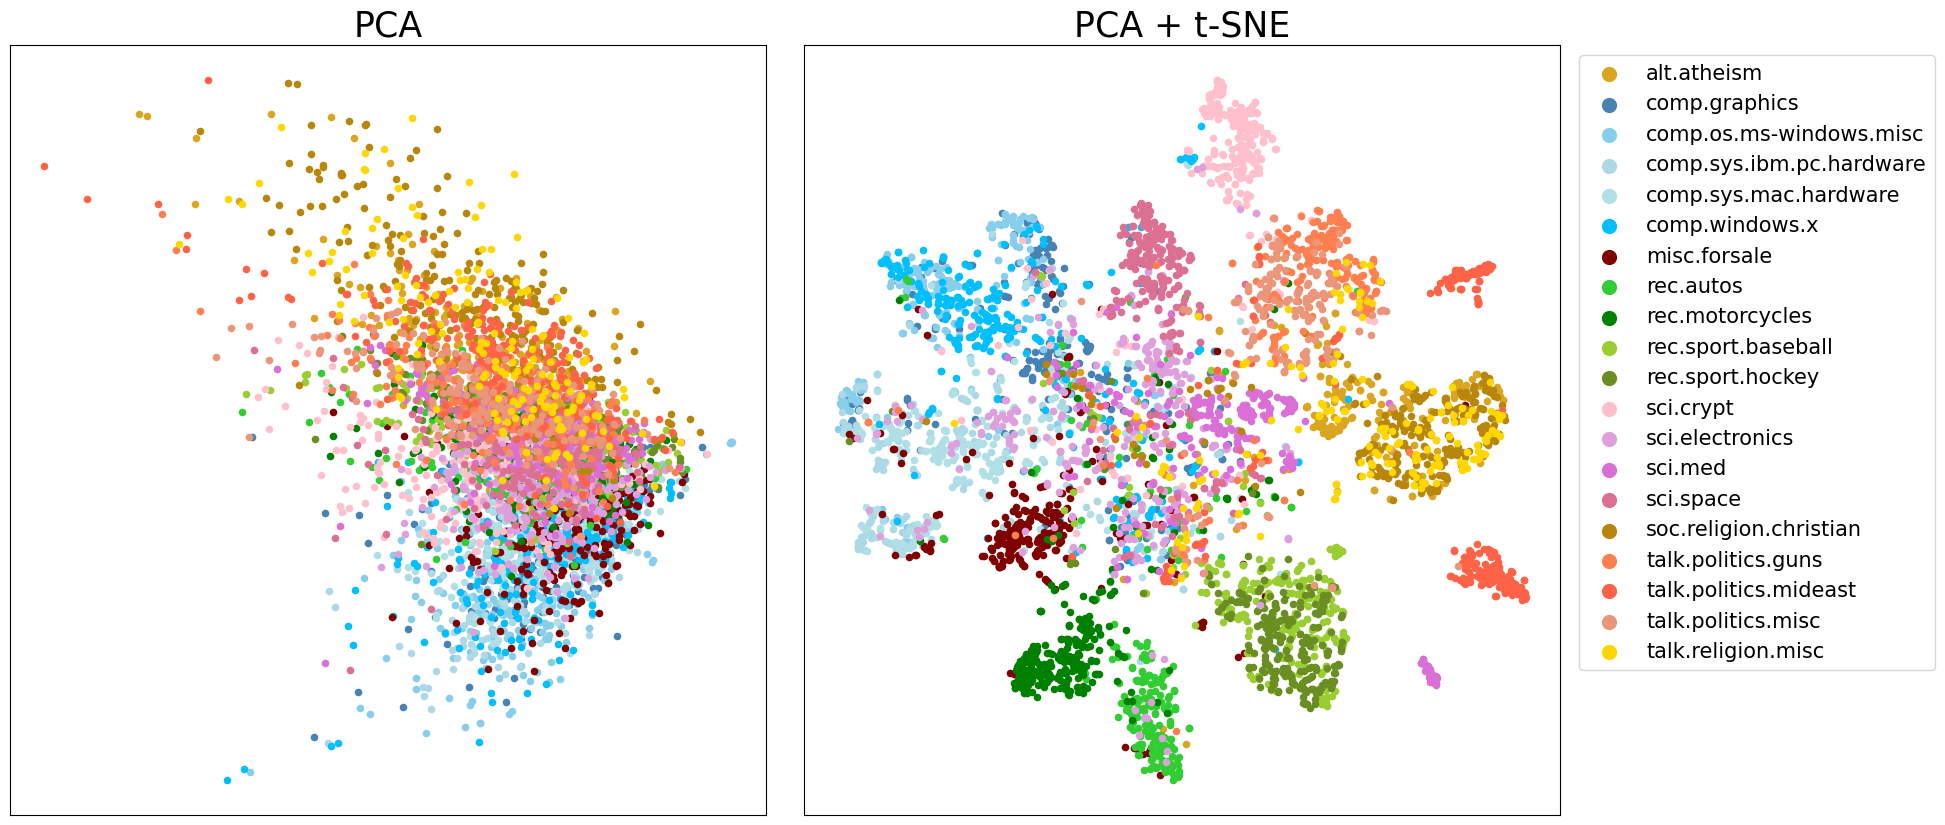

In [13]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots(1, 2, figsize=(20, 10))
for t in targets:
    t_df = zeta_df[zeta_df['target'] == t]
    ax[0].scatter(t_df[0], t_df[1], marker='o', edgecolor='black',
                  linewidth=0, s=30, label=t, c=target_colour[t])
ax[0].set_title(f'PCA', fontsize=25)
ax[0].axes.xaxis.set_visible(False)
ax[0].axes.yaxis.set_visible(False)

for t in targets:
    t_df = tsne_zeta_df[tsne_zeta_df['target'] == t]
    ax[1].scatter(t_df[0], t_df[1], marker='o', edgecolor='black',
                  linewidth=0, s=30, label=t, alpha=1, c=target_colour[t])
ax[1].set_title(f'PCA + t-SNE', fontsize=25)
ax[1].legend(loc='upper right', bbox_to_anchor=(
    1.51, 1), prop={'size': 15}, markerscale=2)
ax[1].axes.xaxis.set_visible(False)
ax[1].axes.yaxis.set_visible(False)

plt.subplots_adjust(wspace=0.05, hspace=0)

# fig.savefig(f"newsgroup.pdf", bbox_inches='tight')

## Hierarchical clustering

In [14]:
from sklearn.metrics import pairwise_distances
from sklearn.cluster import AgglomerativeClustering

def ip_metric(X, Y):
    return np.sum(X * Y)


def ip_affinity(X):
    ips = pairwise_distances(X, metric=ip_metric)
    return np.max(ips) - ips

Find the centroids

In [15]:
idxs = [np.where(np.array(df['target']) == t)[0]
        for t in sorted(df['target'].unique())]
t_zeta = np.array([np.mean(zeta[idx, :], axis=0) for idx in idxs])
t_Y = np.array([np.mean(Y[idx, :],axis = 0) for idx in idxs]).reshape(len(sorted(df['target'].unique())),p)

Perform hierarchical clustering with dot products from: https://arxiv.org/abs/2305.15022

In [16]:
ip_t_clust = AgglomerativeClustering(
    metric=ip_affinity, linkage='average', distance_threshold=0, n_clusters=None)
ip_t_clust = ip_t_clust.fit(t_zeta)

Plot dendrogram

AttributeError: module 'relastat' has no attribute 'plot_dendrogram'

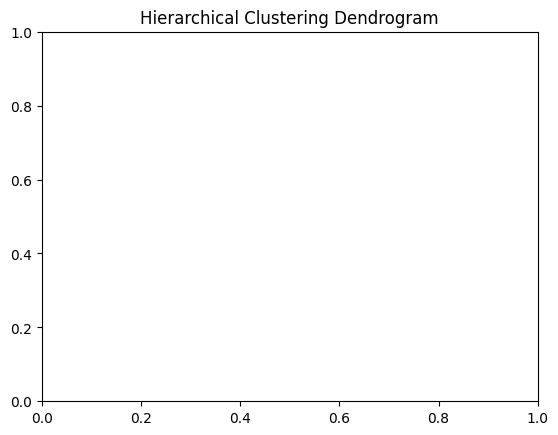

In [17]:
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
rs.plot_dendrogram(ip_t_clust, orientation = 'left', labels=sorted(df['target_names'].unique()))
plt.show()

In [18]:
t_true_ranking = np.array([[0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1],
                           [2, 0, 1, 1, 1, 1, 2, 2, 2, 2, 2,
                               2, 2, 2, 2, 2, 2, 2, 2, 2],
                           [2, 1, 0, 1, 1, 1, 2, 2, 2, 2, 2,
                               2, 2, 2, 2, 2, 2, 2, 2, 2],
                           [3, 2, 2, 0, 1, 2, 3, 3, 3, 3, 3,
                               3, 3, 3, 3, 3, 3, 3, 3, 3],
                           [3, 2, 2, 1, 0, 2, 3, 3, 3, 3, 3,
                               3, 3, 3, 3, 3, 3, 3, 3, 3],
                           [2, 1, 1, 1, 1, 0, 2, 2, 2, 2, 2,
                               2, 2, 2, 2, 2, 2, 2, 2, 2],
                           [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
                               1, 1, 1, 1, 1, 1, 1, 1, 1],
                           [3, 3, 3, 3, 3, 3, 3, 0, 1, 2, 2,
                               3, 3, 3, 3, 3, 3, 3, 3, 3],
                           [3, 3, 3, 3, 3, 3, 3, 1, 0, 2, 2,
                               3, 3, 3, 3, 3, 3, 3, 3, 3],
                           [3, 3, 3, 3, 3, 3, 3, 2, 2, 0, 1,
                               3, 3, 3, 3, 3, 3, 3, 3, 3],
                           [3, 3, 3, 3, 3, 3, 3, 2, 2, 1, 0,
                               3, 3, 3, 3, 3, 3, 3, 3, 3],
                           [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
                               0, 1, 1, 1, 2, 2, 2, 2, 2],
                           [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
                               1, 0, 1, 1, 2, 2, 2, 2, 2],
                           [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
                               1, 1, 0, 1, 2, 2, 2, 2, 2],
                           [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
                               1, 1, 1, 0, 2, 2, 2, 2, 2],
                           [1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
                               2, 2, 2, 2, 0, 2, 2, 2, 1],
                           [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
                               2, 2, 2, 2, 2, 0, 1, 1, 2],
                           [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
                               2, 2, 2, 2, 2, 1, 0, 1, 2],
                           [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
                               2, 2, 2, 2, 2, 1, 1, 0, 2],
                           [1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 0]])


In [19]:
rs.kendalltau_similarity(ip_t_clust, t_true_ranking)

AttributeError: module 'relastat' has no attribute 'kendalltau_similarity'